# Graph Convolutional Networks (GCN) for Predicting Brain Barrier Blood Permeability of Compounds
Jong Hoon Park

Some of my work was inspired by the following work:
https://www.kaggle.com/code/priyanagda/simple-gcn

## Modules / Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# seaborn: Statistical data visualization library
import seaborn as sns

# DeepChem: Deep learning library for cheminformatics
import deepchem as dc
from deepchem.feat import MolGraphConvFeaturizer

# Scikit-learn: Machine learning library
from sklearn.model_selection import train_test_split

# RDKit: Cheminformatics library
from rdkit.Chem import MolFromSmiles

# PyTorch: Deep learning library
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Linear

# PyTorch Geometric: Geometric DL extension library for PyTorch for Graph Neural Networks
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch_geometric.nn
from torch_geometric.nn import GCNConv

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
c:\Users\whdqk\anaconda3\envs\cpu_pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Dataset
deepchem's BBBP (Blood-brain Barrier Penetration) dataset
- 1st column: number of row (unnecessary data)
- 2nd column: compound name
- 3rd column: p_np (boolean labels for permeability of blood brain barrier)
- 4th column: SMILES (simplified molecular-input line-entry system)

_"The blood-brain barrier penetration (BBBP) dataset is designed for the modeling and prediction of barrier permeability. As a membrane separating circulating blood and brain extracellular fluid, the blood-brain barrier blocks most drugs, hormones and neurotransmitters. Thus penetration of the barrier forms a long-standing issue in development of drugs targeting central nervous system."_

Reference:
https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html

In [2]:
# load the BBBP dataset as a Pandas DataFrame
BBBP_dataset = pd.read_csv('BBBP_dataset.csv')
BBBP_dataset.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [3]:
# drop unnecessary columns
BBBP_dataset.drop(columns=BBBP_dataset.columns[0], axis=1,  inplace=True)
BBBP_dataset.head()

,name,p_np,smiles
0,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


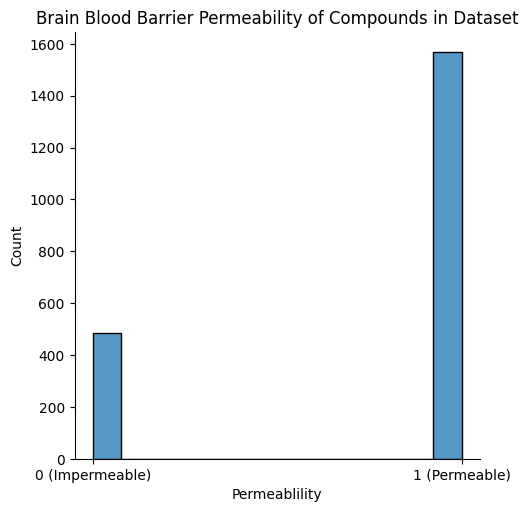

In [4]:
# check the distribution of the target variable
sns.displot(BBBP_dataset['p_np'])
plt.xticks([0, 1], ['0 (Impermeable)', '1 (Permeable)'])
plt.title('Brain Blood Barrier Permeability of Compounds in Dataset')
plt.xlabel('Permeablility')
plt.ylabel('Count')
plt.show()

Compound: M2L-663581
SMILES: OCC(C)(O)c1onc(c2ncn3c2CN(C)C(c4c3cccc4Cl)=O)n1


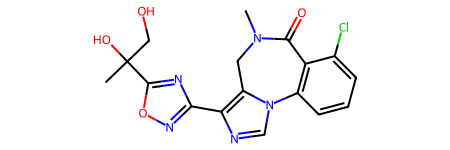

In [5]:
# sample compound
idx_sample = 10 # sample index
name_sample = BBBP_dataset['name'][idx_sample] # name of the sample
print(f"Compound: {name_sample}")
smiles_sample = BBBP_dataset['smiles'][idx_sample] # SMILES string of the sample
print(f"SMILES: {smiles_sample}")
MolFromSmiles(smiles_sample) # convert SMILES string to RDKit molecule to visualize

## Data Pre-Processing
- Featurizer: Transforming raw input data into processed data
  - MolGraphConvFeaturizer: a featurizer of general graph convolution networks for molecules. 
    - Reference: https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html
- Stratified Train/Vaild/Test Split: Splitting dataset into train, valid, and test sets
  - 80% for training
  - 10% for validation
  - 10% for testing

### Example

In [6]:
# Example of using MolGraphConvFeaturizer
'''
This example shows how to use MolGraphConvFeaturizer to featurize a list of SMILES strings.
Default feature length for node is 30.
Default feature length for edge is 11.
Source:
https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#molgraphconvfeaturizer
'''
smiles_samples = ["C1CCC1", "C1=CC=CN=C1"]
featurizer = MolGraphConvFeaturizer(use_edges=True)
output = featurizer.featurize(smiles_samples)
print(f"# of node features: {output[0].num_node_features}") # number of node features per row in adjacency matrix
print(f"# of edge features: {output[0].num_edge_features}") # number of edge features per row in adjacency matrix


# of node features: 30
# of edge features: 11


### Train Validation Test Split

In [7]:
X = BBBP_dataset[['smiles']]
y = BBBP_dataset[['p_np']]

train_test_dataset, val_dataset = train_test_split(
                                        BBBP_dataset, 
                                        test_size=0.1, 
                                        random_state=1, 
                                        stratify=BBBP_dataset['p_np']
                                        )
train_dataset, test_dataset = train_test_split(
                                        train_test_dataset, 
                                        test_size=0.11, 
                                        random_state=1, 
                                        stratify=train_test_dataset['p_np']
                                        )

In [8]:
# train dataset
train_dataset

,name,p_np,smiles
1922,napitane,1,C5CC(CN1CCC(C1)c2ccccc2)c4ccc3OCOc3c4C5
1764,clovoxamine,1,C1=C(C(=N/OCCN)/CCCCOC)C=CC(=C1)Cl
78,Org4428,1,OC12c3c(Oc4c(C)cccc4C2CN(CC1)C)cccc3
311,Lupitidine,0,Cc1ccc(CC2=CN=C(NCCSCc3oc(cc3)C(C)(C)N)NC2=O)cn1
939,tolcapone,0,Cc1ccc(cc1)C(=O)c2cc(O)c(O)c(c2)[N+]([O-])=O
...,...,...,...
1942,oxyridazine,1,C1=C(OC)C=CC3=C1N(C2=C(C=CC=C2)S3)CCC4N(CCCC4)C
119,Fluconazole,1,OC(Cn1cncn1)(Cn2cncn2)c3ccc(F)cc3F
676,levorphanol,1,CN1CC[C@]23CCCC[C@H]2[C@H]1Cc4ccc(O)cc34
1641,trimetrexate,1,C1=C3C(=C(C(=C1)CNC2=CC(=C(C(=C2)OC)OC)OC)C)C(...


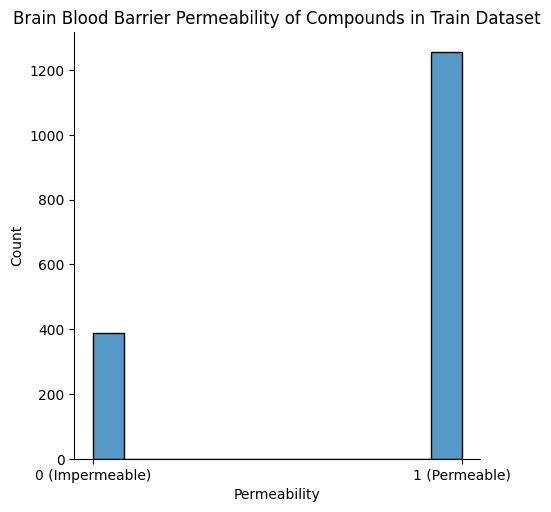

In [9]:
# check the distribution of the target variable in the train dataset
sns.displot(train_dataset['p_np'])
plt.xticks([0, 1], ['0 (Impermeable)', '1 (Permeable)'])
plt.title('Brain Blood Barrier Permeability of Compounds in Train Dataset')
plt.xlabel('Permeability')
plt.ylabel('Count')
plt.show()

In [10]:
# validation dataset
val_dataset

,name,p_np,smiles
628,skb-g,0,c1cc2c(c(OCCNC(Cc3ncccc3)=O)c(c3ccccc3)nc2cc1)...
251,Clofazimine,0,CC(C)N=C1C=C2N(c3ccc(Cl)cc3)c4ccccc4N=C2C=C1Nc...
515,GR94839_A,0,c1(CC(N2[C@H](CN(CC2)C(=O)C)C[N@]2CC[C@H](C2)O...
1174,domoprednate,1,[C@]4([C@@]3([C@H]([C@H]2[C@@H]([C@@]1(C(=CC(=...
877,moxalactam,0,CO[C@]1(NC(=O)C(C(O)=O)c2ccc(O)cc2)[C@H]3OCC(=...
...,...,...,...
1415,nisobamate,1,C(C(COC(N)=O)(C(CC)C)C)OC(NC(C)C)=O
1903,methastyridone,1,C1=CC=CC=C1/C=C/C2C(NC(O2)(C)C)=O
291,Metronidazole,1,Cc1ncc(n1CCO)[N+]([O-])=O
163,prazepam,1,Clc1ccc2N(CC3CC3)C(=O)CN=C(c4ccccc4)c2c1


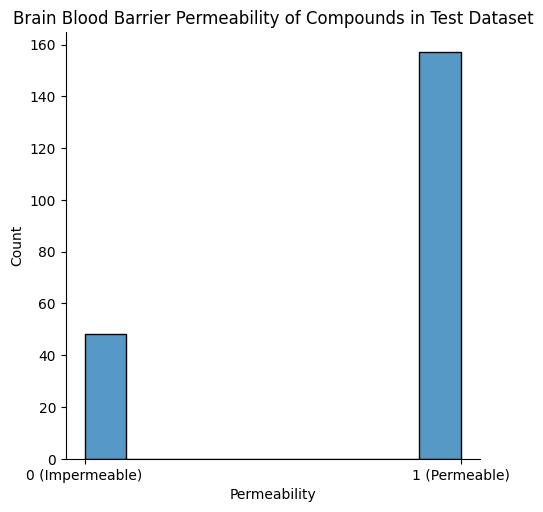

In [11]:
# check the distribution of the target variable in the validation dataset
sns.displot(val_dataset['p_np'])
plt.xticks([0, 1], ['0 (Impermeable)', '1 (Permeable)'])
plt.title('Brain Blood Barrier Permeability of Compounds in Test Dataset')
plt.xlabel('Permeability')
plt.ylabel('Count')
plt.show()

In [12]:
# test dataset
test_dataset

,name,p_np,smiles
383,Zolantidine,1,OC(=O)\C=C/C(O)=O.OC(=O)\C=C/C(O)=O.C1CCN(CC1)...
923,sisomicin,0,CN[C@@H]1[C@@H](O)[C@H](OC[C@]1(C)O)O[C@H]2[C@...
1830,flucindol,1,CN(C)C3CCc2[nH]c1c(F)cc(F)cc1c2C3
1600,thiopropazate,1,C1=C(Cl)C=CC3=C1N(C2=C(C=CC=C2)S3)CCCN4CCN(CCO...
1108,clopenthixol/zuclopenthixol,1,C1=C(Cl)C=CC3=C1\C(C2=C(C=CC=C2)S3)=C/CCN4CCN(...
...,...,...,...
726,Ethambutol,0,CC[C@@H](CO)NCCN[C@@H](CC)CO
594,Pirenzepine,1,CN1CCN(CC1)CC(=O)N2c3ccccc3C(=O)Nc4cccnc24
630,skb-i,0,c1cc2c(C(N[C@@H](CC)c3ccccc3)=O)c(c(nc2cc1)c1c...
738,apramycin,0,CN[C@H]1[C@@H](O)[C@H]2O[C@@H](O[C@@H]3[C@@H](...


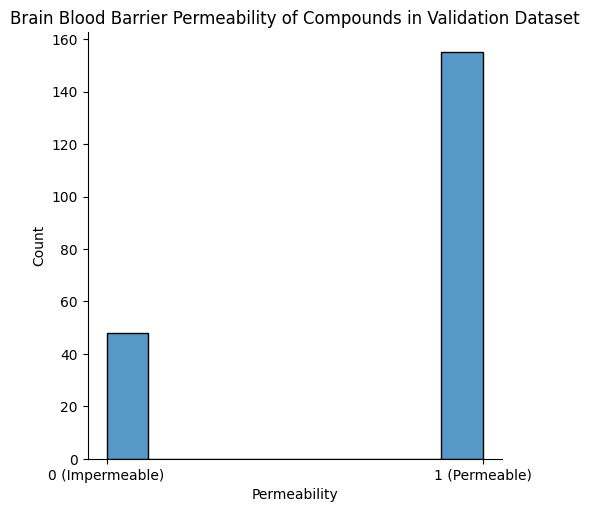

In [13]:
# check the distribution of the target variable in the test dataset
sns.displot(test_dataset['p_np'])
plt.xticks([0, 1], ['0 (Impermeable)', '1 (Permeable)'])
plt.title('Brain Blood Barrier Permeability of Compounds in Validation Dataset')
plt.xlabel('Permeability')
plt.ylabel('Count')
plt.show()

### Custom Dataset

In [14]:
def custom_dataset(dataset_):
	'''
	Read data from *.npy file. 
	Each npy file has 4 features:
		- node_f: node features
		- edge_index: edge index
		- edge_attr: edge attributes
		- pos: atom coordinates
		- y: target value (boolean permeabiltiy)
	'''
	featurizer = MolGraphConvFeaturizer(use_edges=True) # featurizer
	dataset = []

	for i, data in dataset_.iterrows():
		smiles_featurized = featurizer.featurize(data["smiles"])

		try:
			node_f = smiles_featurized[0].node_features,
			edge_index = smiles_featurized[0].edge_index,
			edge_features = smiles_featurized[0].edge_features
			# pos = smiles_featurized[0].node_pos_features
		except: # if rdkit fails to parse the SMILES string in BBBP dataset
			continue

		sample = Data(x = torch.tensor(node_f, dtype=torch.float).squeeze(0), 
					edge_index = torch.tensor(edge_index, dtype=torch.long).squeeze(0), 
					edge_features = torch.tensor(edge_features, dtype=torch.float), 
					y = torch.tensor([data["p_np"]], dtype=torch.int64)
					)

		dataset.append(sample)

	return dataset


In [15]:
# create custom datasets
train_set = custom_dataset(train_dataset)
val_set = custom_dataset(val_dataset)
test_set = custom_dataset(test_dataset)

C:\Users\whdqk\AppData\Local\Temp\ipykernel_22548\3090199101.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  sample = Data(x = torch.tensor(node_f, dtype=torch.float).squeeze(0),
[01:51:36] WARNING: not removing hydrogen atom without neighbors
[01:51:37] WARNING: not removing hydrogen atom without neighbors
[01:51:38] WARNING: not removing hydrogen atom without neighbors
[01:51:39] Explicit valence for atom # 5 N, 4, is greater than permitted
Failed to featurize datapoint 0, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotope

In [16]:
print(train_set[0]) # the first train sample
print(train_set[1]) # the second train sample
print(train_set[2]) # the third train sample
print(train_set[3]) # the fourth train sample

Data(x=[25, 30], edge_index=[2, 58], y=[1], edge_features=[58, 11])
Data(x=[19, 30], edge_index=[2, 38], y=[1], edge_features=[38, 11])
Data(x=[22, 30], edge_index=[2, 50], y=[1], edge_features=[50, 11])
Data(x=[29, 30], edge_index=[2, 62], y=[1], edge_features=[62, 11])


## Graph Convolutional Network

In [17]:
# Graph Convolutional Network model
class GCN(nn.Module):
	'''
	Graph Neural Network class
	'''
	def __init__(self, n_features, n_classes):
		'''
		n_features: number of features
		n_classes: number of classes
		'''
		super(GCN, self).__init__()
		'''
		class GCNConv(in_channels: int, 
						out_channels: int, 
						improved: bool = False, 
						cached: bool = False, 
						add_self_loops: bool = True, 
						normalize: bool = True, 
						bias: bool = True, **kwargs)
		'''
		self.conv1 = GCNConv(n_features, 64)
		self.conv2 = GCNConv(64, 64)
		self.conv3 = GCNConv(64, 128)
		self.conv4 = GCNConv(128, 256)
		self.conv5 = GCNConv(256, 512)
		self.pool = torch_geometric.nn.global_add_pool
		self.linear1 = Linear(512, 256)
		self.linear2 = Linear(256, n_classes)

	# Forward function
	def forward(self, data):
		x , edge_index, edge_features = data.x, data.edge_index, data.edge_features

		x = self.conv1(x, edge_index)
		x = F.relu(x)
		x = F.dropout(x, p=0.5, training=self.training)
		x = self.conv2(x, edge_index)
		x = F.relu(x)
		x = self.conv3(x, edge_index)
		x = F.relu(x)
		x = self.conv4(x, edge_index)
		x = F.relu(x)
		x = self.conv5(x, edge_index)
		x = self.pool(x, batch=data.batch)
		x = F.relu(x)
		x = self.linear1(x)
		x = F.relu(x)
		x = self.linear2(x)
		# x = F.log_softmax(x, dim=1) # don't need to use log_softmax because we use CrossEntropyLoss which already has log_softmax

		return x

## Training & Results

In [18]:
# check pytorch cuda and use cuda if possible
check_device = torch.cuda.is_available()
print('*' * 50)
if check_device:  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************


C:\Users\whdqk\AppData\Local\Temp\ipykernel_22548\915589029.py:7: UserWarning: CUDA not found! Training may be slow......
  warnings.warn('CUDA not found! Training may be slow......')


In [19]:
# device
device = "cuda" if torch.cuda.is_available() else "cpu" # use GPU if available

## 

c:\Users\whdqk\anaconda3\envs\cpu_pytorch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 1, Train loss: 0.00936, Validation loss: 0.00875
Sum MSE Validation Loss: 1.7770614624023438
Epoch: 2, Train loss: 0.00868, Validation loss: 0.00779
Sum MSE Validation Loss: 1.581705391407013
Epoch: 3, Train loss: 0.00808, Validation loss: 0.00719
Sum MSE Validation Loss: 1.4593560993671417
Epoch: 4, Train loss: 0.00752, Validation loss: 0.00696
Sum MSE Validation Loss: 1.4123198688030243
Epoch: 5, Train loss: 0.00721, Validation loss: 0.00676
Sum MSE Validation Loss: 1.3729222118854523
Epoch: 6, Train loss: 0.00723, Validation loss: 0.00673
Sum MSE Validation Loss: 1.366700828075409
Epoch: 7, Train loss: 0.0069, Validation loss: 0.00657
Sum MSE Validation Loss: 1.3346633315086365
Epoch: 8, Train loss: 0.00699, Validation loss: 0.00659
Sum MSE Validation Loss: 1.338077962398529
Epoch: 9, Train loss: 0.00683, Validation loss: 0.00648
Sum MSE Validation Loss: 1.3155814707279205
Epoch: 10, Train loss: 0.00683, Validation loss: 0.00645
Sum MSE Validation Loss: 1.308935821056366
Epoc

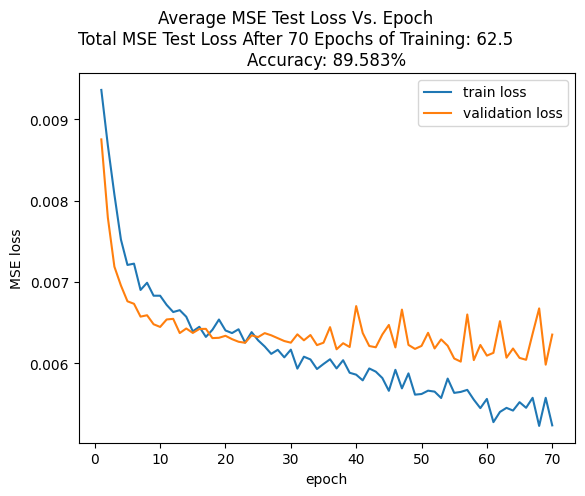

In [20]:
# load data and build the data loader
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

# the number of features in the dataset
n_features = train_set[0].num_features

# the number of classes
n_classes = 2 # binary classification (permeable or impermeable)

# model
model = GCN(n_features, n_classes).to(device)

# Hyperparameters
num_epoch = 70 # number of epochs
lr = 3e-4 # learning rate
weight_decay1 = 1e-5 # L2 regularization
weight_decay2 = 1e-4 # L2 regularization

# loss function
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(
            [dict(params=model.conv1.parameters(), weight_decay=weight_decay1),
            dict(params=model.conv2.parameters(), weight_decay=weight_decay1),
            dict(params=model.conv3.parameters(), weight_decay=weight_decay2),
            dict(params=model.conv4.parameters(), weight_decay=weight_decay2),
            dict(params=model.conv5.parameters(), weight_decay=weight_decay2)],
            lr=lr, # learning rate
            amsgrad=True # AMSGrad is a variant of Adam optimizer
                        )

# TRAINING LOOP
hist = {"train_loss":[], "validation_loss":[]}
for epoch in range(1, 1+num_epoch):

    # TRAINING
    model.train()
    train_loss_all = 0
    for data in train_loader:
        data = data.to(device)
        # SET GRADIENT TO ZERO
        optimizer.zero_grad()
        # FORWARD PASS
        output = model(data) # predicted output
        output = output
        # CALCULATE LOSS
        loss = criterion(output, data.y)
        train_loss_all += loss.item()
        # BACKPROPAGATION
        loss.backward()
        # UPDATE WEIGHTS
        optimizer.step()
    train_loss = train_loss_all / len(train_set) # train loss for each epoch

    # VALIDATION
    model.eval()
    with torch.no_grad():
        val_loss_all = 0
        for data in val_loader:
            data = data.to(device)
            # FORWARD PASS
            output = model(data)
            # CALCULATE LOSS
            loss = criterion(output, data.y)
            val_loss_all += loss.item()
        val_loss = val_loss_all / len(val_set)
        # PLOT LOSSES
        hist["train_loss"].append(train_loss)
        hist["validation_loss"].append(val_loss)
        print(f'Epoch: {epoch}, Train loss: {train_loss:.3}, Validation loss: {val_loss:.3}')
        print(f'Sum MSE Validation Loss: {val_loss_all}')

# TEST
with torch.no_grad():
    test_loss_all = 0
    prediction = np.zeros(len(test_set))
    label = np.zeros(len(test_set))
    idx = 0
    accuracy = 0
    for data in test_loader:
        data = data.to(device)
        output = model(data)
        # CALCULATE LOSS
        loss = criterion(output, data.y)
        test_loss_all += loss.item() * data.num_graphs
        # FORWARD PASS
        outputs = model(data)
        # PREDICTION
        predicted = torch.argmax(outputs, 1)
        # ACCURACY
        accuracy += (predicted == data.y).sum().item() / len(data.y)
        idx += 1
    final_accuracy = 100 * accuracy / idx
    print(f"Fianl Accuracy: {final_accuracy:.3f}%")

# VISUALIZATION
ax = plt.subplot(1,1,1)
ax.plot([e for e in range(1,1+num_epoch)], hist["train_loss"], label="train loss")
ax.plot([e for e in range(1,1+num_epoch)], hist["validation_loss"], label="validation loss")
plt.title(f"Average MSE Test Loss Vs. Epoch\
            \nTotal MSE Test Loss After {num_epoch} Epochs of Training: {test_loss_all:.3}\
            \nAccuracy: {final_accuracy:.3f}%")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
ax.legend()
plt.show()


## Let's use the trained model to predict the blood-brain barrier permeability of a compound.

xylazine
C1=C(C(=C(C=C1)C)NC2=NCCCS2)C


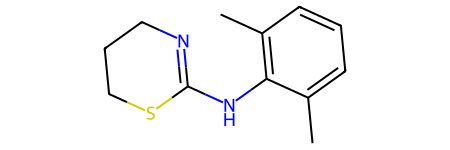

In [21]:
idx = 5 # index of sample compound for testing
test_mol_name = test_dataset['name'].iloc[idx] # name of sample compound for testing
print(test_mol_name)
test_mol_smile = test_dataset['smiles'].iloc[idx] # SMILES string of sample compound for testing
print(test_mol_smile)
MolFromSmiles(test_mol_smile) # convert SMILES string to RDKit molecule to visualize

In [22]:
output = model(test_set[idx].to(device)) # output from trained model
pred = torch.argmax(output, 1) # prediction
if pred == 1:
    pred = f'{test_mol_name} is permeable'
else:
    pred = f'{test_mol_name} is impermeable'

ground_truth = test_set[idx].y # ground truth label
if ground_truth == 1:
    ground_truth = f'{test_mol_name} is permeable.'
else:
    ground_truth = f'{test_mol_name} is impermeable.'

print(f"prediction: {pred}\nground truth: {ground_truth}")


prediction: xylazine is permeable
ground truth: xylazine is permeable.


## Why is the validation loss lower than the training loss for the first few epochs of training?

In the beginning, I did not understand why the validation loss was lower than the training loss for the first few epochs of training. I initially had thought that the training loss should be lower than the validation loss. However, I did not find any data leakage issue to my validation dataset. Thus, I decided to further research the cause of this phenomenon.

Below are possible reasons for having a lower validation loss than the training loss.
1. __Dropout is not applied during validation while it is applied during training.__ I used the dropout technique after my convolution layer. Remember, dropout is a regularization technique that randomly drops out some of the neurons in the network. Thus, the network is less likely to overfit during training. However, during validation, the network is not trained. Thus, the network is more likely to overfit during validation. Therefore, the validation loss is higher than the training loss.
2. __Regularization is not applied during validation while it is applied during training.__ I used weight decay (L2 regularization) after each of my convolution layer. Remember, regularization is a technique that penalizes the loss function. Thus, the network is less likely to overfit during training. However, during validation, the network is not trained. Thus, the network is more likely to overfit during validation. Therefore, the validation loss is higher than the training loss.

### References:

[1] https://pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/

[2] https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e#:~:text=The%20regularization%20terms%20are%20only,loss%20than%20the%20training%20set.
